<div style="width:100%;text-align: top;"> <img align=middle src="https://mmo.aiircdn.com/141/5ed59862e602f.png" alt="Heat beating" style="height:400px;margin-top:1rem;"> </div>

## BUILDING ENERGY CONSUMPTION ANALYSIS

Climate change is a global challenge and carbon pollution knows no boundaries.<br>
In 2011, Seattle adopted the goal to become carbon neutral by 2050. The overall approach to carbon reductions in the buildings is to provide information, financial and other incentives, and technical assistance, while establishing strong standards for efficiency and emissions. <br>
As part of the City of Seattle, our team will focus on Green House Gas Emissions from non residential buildings.<br>
Our final objective is to predict CO2 emissions and the Total Energy Use for buildings that do not have yet any measurements.  <br>
To achieve this

In [613]:
#! usr/bin/env python 3
# coding: utf-8

# Importing librairies

import numpy as np                # numerical data processing
import pandas as pd               # numerical tables & time series
import scipy as sp                # numerical integration, interpolation, optimization, linear algebra, and statistics
import scipy.stats as st          # statistical functions
import seaborn as sns             # statistical data visualization
import matplotlib.pyplot as plt   # static, animated, and interactive visualizations in Python

from sklearn import model_selection
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from math import sqrt
from IPython.display import HTML
import warnings
warnings.filterwarnings('ignore')


In [688]:
from IPython.display import HTML
import random

def hide_toggle(for_next=False):
    this_cell = """$('div.cell.code_cell.rendered.selected')"""
    next_cell = this_cell + '.next()'

    toggle_text = 'Toggle show/hide'  # text shown on toggle link
    target_cell = this_cell  # target cell to control with toggle
    js_hide_current = ''  # bit of JS to permanently hide code in current cell (only when toggling next cell)

    if for_next:
        target_cell = next_cell
        toggle_text += ' next cell'
        js_hide_current = this_cell + '.find("div.input").hide();'

    js_f_name = 'code_toggle_{}'.format(str(random.randint(1,2**64)))

    html = """
        <script>
            function {f_name}() {{
                {cell_selector}.find('div.input').toggle();
            }}

            {js_hide_current}
        </script>

        <a href="javascript:{f_name}()">{toggle_text}</a>
    """.format(
        f_name=js_f_name,
        cell_selector=target_cell,
        js_hide_current=js_hide_current, 
        toggle_text=toggle_text
    )

    return HTML(html)

In [614]:
# Transforming input files.csv to dataframes

df_data = pd.read_csv("data_cleaned.csv")
df_data = df_data.drop(['Unnamed: 0'], axis=1)
df_data.head(2)


,OSEBuildingID,DataYear,BuildingType,PrimaryPropertyType,PropertyName,Neighborhood,NumberofBuildings,NumberofFloors,PropertyGFATotal,LargestPropertyUseType,...,Longitude,Address,City,State,ZipCode,AgeofBuilding,MeanBuildingGFA,MeanFloorGFA,BuildingGFApct,ParkingGFApct
0,1,2015,NonResidential,Hotel,Mayflower Park Hotel,Downtown,1.0,12.0,88434,Hotel,...,-122.337997,405 Olive Way,Seattle,WA,98101.0,88,88434.0,7369.5,1.0,0.0
1,1,2016,NonResidential,Hotel,Mayflower Park Hotel,Downtown,1.0,12.0,88434,Hotel,...,-122.337990,405 Olive Way,Seattle,WA,98101.0,89,88434.0,7369.5,1.0,0.0


In [615]:
target_features = ['SiteEnergyUse(kBtu)','GHGEmissions(MetricTonsCO2e)']
df_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3173 entries, 0 to 3172
Data columns (total 26 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   OSEBuildingID                 3173 non-null   int64  
 1   DataYear                      3173 non-null   int64  
 2   BuildingType                  3173 non-null   object 
 3   PrimaryPropertyType           3173 non-null   object 
 4   PropertyName                  3173 non-null   object 
 5   Neighborhood                  3173 non-null   object 
 6   NumberofBuildings             3173 non-null   float64
 7   NumberofFloors                3173 non-null   float64
 8   PropertyGFATotal              3173 non-null   int64  
 9   LargestPropertyUseType        3104 non-null   object 
 10  YearsENERGYSTARCertified      183 non-null    object 
 11  ENERGYSTARScore               2104 non-null   float64
 12  SiteEnergyUse(kBtu)           3173 non-null   float64
 13  GHG

In [616]:
non_reg = ['YearsENERGYSTARCertified']
df_data.drop(non_reg, axis=1, inplace=True)

In [617]:
loc_features = ['Outlier', 'OSEBuildingID', 'PropertyName', 'Address', 'City', 'State', 'ZipCode']
df_data_loc = df_data[loc_features]
df_data.drop(loc_features, axis=1, inplace = True)

In [618]:
space = ['Latitude', 'Longitude']
df_data_nonloc = df_data.drop(space, axis=1)

In [619]:
df_data_non_ener = df_data_nonloc.drop(['ENERGYSTARScore'], axis=1)
df_data_non_ener['DataYear'] = df_data_non_ener['DataYear'].astype(str)

In [620]:
df_data_non_ener.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3173 entries, 0 to 3172
Data columns (total 15 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   DataYear                      3173 non-null   object 
 1   BuildingType                  3173 non-null   object 
 2   PrimaryPropertyType           3173 non-null   object 
 3   Neighborhood                  3173 non-null   object 
 4   NumberofBuildings             3173 non-null   float64
 5   NumberofFloors                3173 non-null   float64
 6   PropertyGFATotal              3173 non-null   int64  
 7   LargestPropertyUseType        3104 non-null   object 
 8   SiteEnergyUse(kBtu)           3173 non-null   float64
 9   GHGEmissions(MetricTonsCO2e)  3173 non-null   float64
 10  AgeofBuilding                 3173 non-null   int64  
 11  MeanBuildingGFA               3173 non-null   float64
 12  MeanFloorGFA                  3173 non-null   float64
 13  Bui

In [621]:
#df_data_non_ener['LargestPropertyUseType'] = df_data_non_ener['LargestPropertyUseType'].fillna("Nodata")

In [622]:
numerical_features = df_data_non_ener.select_dtypes(include=['int64','float64'])
categorical_features = df_data_non_ener.select_dtypes(exclude=['int64','float64']) 

In [623]:
numerical_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3173 entries, 0 to 3172
Data columns (total 10 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   NumberofBuildings             3173 non-null   float64
 1   NumberofFloors                3173 non-null   float64
 2   PropertyGFATotal              3173 non-null   int64  
 3   SiteEnergyUse(kBtu)           3173 non-null   float64
 4   GHGEmissions(MetricTonsCO2e)  3173 non-null   float64
 5   AgeofBuilding                 3173 non-null   int64  
 6   MeanBuildingGFA               3173 non-null   float64
 7   MeanFloorGFA                  3173 non-null   float64
 8   BuildingGFApct                3173 non-null   float64
 9   ParkingGFApct                 3173 non-null   float64
dtypes: float64(8), int64(2)
memory usage: 248.0 KB


In [624]:
categorical_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3173 entries, 0 to 3172
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   DataYear                3173 non-null   object
 1   BuildingType            3173 non-null   object
 2   PrimaryPropertyType     3173 non-null   object
 3   Neighborhood            3173 non-null   object
 4   LargestPropertyUseType  3104 non-null   object
dtypes: object(5)
memory usage: 124.1+ KB


### LINEAR REGRESSION and its variants - No Optimization

In order to create a regression model that can the numerical features to the Energy Use or GHG Emissions, a baseline model will be built to get a basis for comparison. Linear regression will then be computed and compared to the baseline to check any improvement in our model.

Step 1: __DATA SELECTION__

In [625]:
# Data Selection 
y = df_data_non_ener['SiteEnergyUse(kBtu)'].values
X = numerical_features.drop(target_features, axis=1)


Step 2: __STANDARDIZATION__<br>

StandardScaler standardizes a feature by subtracting the mean and then scaling to unit variance. Unit variance means dividing all the values by the standard deviation. StandardScaler results in a distribution with a standard deviation equal to 1. 

In [626]:
# Standardization
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X)
X_scaled = scaler.transform(X)

Step 3: __TRAIN-TEST SPLIT EVALUATION__<br>

The procedure involves taking a dataset and dividing it into two subsets. The first subset is used to fit the model and is referred to as the training dataset. The second subset is not used to train the model; instead, the input element of the dataset is provided to the model, then predictions are made and compared to the expected values. This second dataset is referred to as the test dataset.<br>
The objective is to estimate the performance of the machine learning model on new data: data not used to train the model.

In [627]:
from sklearn.model_selection import train_test_split, cross_val_score
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)


Step 4: __BASELINE CREATION__<br>

The Dummy Regressor is a kind of Regressor that gives prediction based on simple strategies without paying any attention to the input Data. The sklearn library provides Dummy Regressor which is used to set up a baseline for comparing different regressions. Training the dummy model is similar to training any regular regression model, except for the strategies. The main role of strategy is to predict target values without any influence of the training data.<br> We are here using the strategy "mean" which is the default strategy used by the Dummy Regressor. It always predicts the mean of the training target values.

In [628]:
from sklearn.dummy import DummyRegressor
dummy_reg = DummyRegressor(strategy="mean")
dummy_reg.fit(X_train, y_train)
dummy_pred = dummy_reg.predict(X_test)

To evaluate our regression model, we compute few meaningful prameters to estimate how far our predictions are from the actual data:

__MAE__ is the sum of absolute differences between our target and predicted variables.<br>
__MSE__ measures the average squared difference between the estimated values and the actual value.<br>
__RMSE__ is the standard deviation of the residuals.<br>
__RSS__ is the residuals sum of squares.<br>
__R²__ is the coefficient of determination and evaluates the scatter of the data points around the fitted regression line.

In [629]:
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

def algo_model(y_actual, y_forecast):
    """Return metrics for model evaluation in regression"""
    
    y_actual, y_forecast = np.array(y_actual), np.array(y_forecast)
    
    rss = np.sum((y_actual - y_forecast)**2)
    mse = mean_squared_error(y_actual, y_forecast)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_actual, y_forecast)
    
    functions = {"Functions":["Mean Squared Error (MSE)", "Residual Sum of Squares (RSS)",
                               "Root Mean Squared Error (RMSE)",
                              "Mean Absolute Error (MAE)", "Coefficient of determination (R²)"],
                              "Results":[mse, rss, rmse, mae, r2_score(y_actual, y_forecast)]}
    
    df_functions = pd.DataFrame(functions) 
    return df_functions

dummy_metrics = algo_model(y_test, dummy_pred).rename(columns={'Results':'Baseline'})
dummy_metrics.index = np.arange(1, len(dummy_metrics)+1)
dummy_metrics

,Functions,Baseline
1,Mean Squared Error (MSE),3.767654e+14
2,Residual Sum of Squares (RSS),3.586807e+17
3,Root Mean Squared Error (RMSE),1.941045e+07
4,Mean Absolute Error (MAE),8.665980e+06
5,Coefficient of determination (R²),-5.615692e-04


As can be seen from the above result, the expected Dummy Regressor always predict the R² score as 0, since it is always predicting a constant without having an insight of the output. This baseline will be a useful point for comparison with our linear regression.

Step 5-1: __LINEAR REGRESSION__<br>


The simplest form of regression is the linear regression, which assumes that the predictors have a linear relationship with the target variable. The input variables are assumed to have a Gaussian distribution. Another assumption is that the predictors are not highly correlated with each other (a problem called multi-collinearity).

In [630]:
from sklearn.linear_model import LinearRegression
regr = LinearRegression()
regr.fit(X_train, y_train)
regr_forecast = regr.predict(X_test)
regr_metrics = algo_model(y_test, regr_forecast).rename(columns={'Results':'Linear Regression'})
regr_metrics.index = np.arange(1, len(regr_metrics)+1)
regr_metrics = pd.concat([dummy_metrics,regr_metrics['Linear Regression']], axis=1)
round(regr_metrics, 2)

,Functions,Baseline,Linear Regression
1,Mean Squared Error (MSE),3.767654e+14,2.192667e+14
2,Residual Sum of Squares (RSS),3.586807e+17,2.087419e+17
3,Root Mean Squared Error (RMSE),1.941045e+07,1.480766e+07
4,Mean Absolute Error (MAE),8.665980e+06,5.331719e+06
5,Coefficient of determination (R²),-0.000000e+00,4.200000e-01


As seen in this table, the coefficient of determination R² is much better than for the baseline which indicates that the performed linear regression is a better fit for our data but still far away from a golden solution which would approach 1 in ideal conditions. Plotting the acual data vs. the forecasts, we can have a display of the trends of the data.

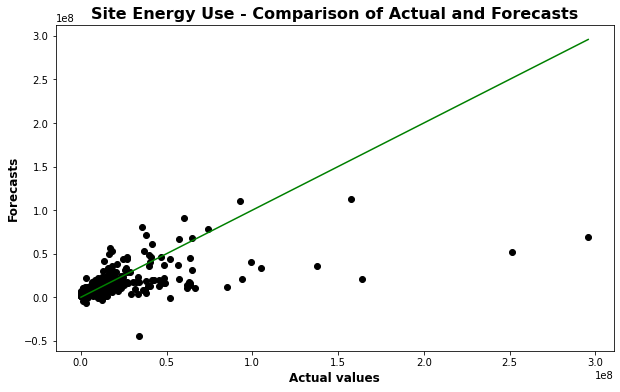

In [631]:
def forecast_comp(y_actual, y_forecast):
    X_plot = [y_actual.min(), y_actual.max()]
    fig = plt.figure(figsize=(10,6))
    plt.scatter(y_actual, y_forecast, color='black')
    plt.plot(X_plot, X_plot, color='g')
    plt.xlabel("Actual values", weight = "bold", fontsize=12)
    plt.ylabel("Forecasts", weight = "bold", fontsize=12)
    plt.title("Site Energy Use - Comparison of Actual and Forecasts", weight = "bold", fontsize=16)
    plt.show()
forecast_comp(y_actual=y_test, y_forecast = regr_forecast)


Step 5-2: __RIDGE REGRESSION__<br>

Ridge regression is an extension of linear regression where the loss function is modified to minimize the complexity of the model. This modification is done by adding a penalty parameter that is equivalent to the square of the magnitude of the coefficients.

In [632]:

rr = Ridge(alpha=1)
rr.fit(X_train, y_train) 
rr_forecast= rr.predict(X_test)
ridge_metrics = algo_model(y_test, rr_forecast).rename(columns={'Results':'Ridge Regression'})
ridge_metrics.index = np.arange(1, len(ridge_metrics)+1)
ridge_metrics = pd.concat([regr_metrics,ridge_metrics['Ridge Regression']], axis=1)
round(ridge_metrics, 2)


,Functions,Baseline,Linear Regression,Ridge Regression
1,Mean Squared Error (MSE),3.767654e+14,2.192667e+14,2.186133e+14
2,Residual Sum of Squares (RSS),3.586807e+17,2.087419e+17,2.081199e+17
3,Root Mean Squared Error (RMSE),1.941045e+07,1.480766e+07,1.478558e+07
4,Mean Absolute Error (MAE),8.665980e+06,5.331719e+06,5.324672e+06
5,Coefficient of determination (R²),-0.000000e+00,4.200000e-01,4.200000e-01


Step 5-3: __LASSO REGRESSION__<br>

Lasso regression, or the Least Absolute Shrinkage and Selection Operator, is also a modification of linear regression. In Lasso, the loss function is modified to minimize the complexity of the model by limiting the sum of the absolute values of the model coefficients (also called the l1-norm).

In [633]:
model_lasso = Lasso(alpha=1)
model_lasso.fit(X_train, y_train) 
lasso_forecast= model_lasso.predict(X_test)
lasso_metrics = algo_model(y_test, lasso_forecast).rename(columns={'Results':'Lasso Regression'})
lasso_metrics.index = np.arange(1, len(lasso_metrics)+1)
lasso_metrics = pd.concat([ridge_metrics,lasso_metrics['Lasso Regression']], axis=1)
round(lasso_metrics, 2)


,Functions,Baseline,Linear Regression,Ridge Regression,Lasso Regression
1,Mean Squared Error (MSE),3.767654e+14,2.192667e+14,2.186133e+14,2.192667e+14
2,Residual Sum of Squares (RSS),3.586807e+17,2.087419e+17,2.081199e+17,2.087419e+17
3,Root Mean Squared Error (RMSE),1.941045e+07,1.480766e+07,1.478558e+07,1.480766e+07
4,Mean Absolute Error (MAE),8.665980e+06,5.331719e+06,5.324672e+06,5.331718e+06
5,Coefficient of determination (R²),-0.000000e+00,4.200000e-01,4.200000e-01,4.200000e-01


Step 5-3: __ELASTICNET REGRESSION__<br>

ElasticNet combines the properties of both Ridge and Lasso regression. It works by penalizing the model using both the l2-norm and the l1-norm.

In [634]:
model_enet = ElasticNet(alpha = 1)
model_enet.fit(X_train, y_train) 
enet_forecast= model_enet.predict(X_test)
enet_metrics = algo_model(y_test, enet_forecast).rename(columns={'Results':'ElasticNet Regression'})
enet_metrics.index = np.arange(1, len(enet_metrics)+1)
enet_metrics = pd.concat([lasso_metrics,enet_metrics['ElasticNet Regression']], axis=1)
round(enet_metrics, 2)

,Functions,Baseline,Linear Regression,Ridge Regression,Lasso Regression,ElasticNet Regression
1,Mean Squared Error (MSE),3.767654e+14,2.192667e+14,2.186133e+14,2.192667e+14,2.273809e+14
2,Residual Sum of Squares (RSS),3.586807e+17,2.087419e+17,2.081199e+17,2.087419e+17,2.164666e+17
3,Root Mean Squared Error (RMSE),1.941045e+07,1.480766e+07,1.478558e+07,1.480766e+07,1.507916e+07
4,Mean Absolute Error (MAE),8.665980e+06,5.331719e+06,5.324672e+06,5.331718e+06,5.249495e+06
5,Coefficient of determination (R²),-0.000000e+00,4.200000e-01,4.200000e-01,4.200000e-01,4.000000e-01


Regressions with numerical data only. Results 

### SECOND LINEAR REGRESSION: ONE HOT ENCODING

In order to improve our linear regression, we'll incorporate categorical variables and check if it gives values/improvement from our former linear regression.
A one hot encoding is a representation of categorical variables as binary vectors.
This first requires that the categorical values be mapped to integer values.
Then, each integer value is represented as a binary vector that is all zero values except the index of the integer, which is marked with a 1. <br>

In [635]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# We incorporate categories for Energy Use in the regression

num_data = list(X.columns)
cat_data = list(categorical_features.columns)
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(transformers=
                                 [('num', scaler, num_data),
                                  ('cat', categorical_transformer, cat_data)])

pipe1 = Pipeline(steps=[('preprocessor', preprocessor),
                             ('regressor', LinearRegression())])

X1 = df_data_non_ener[num_data + cat_data]
y1 = df_data_non_ener['SiteEnergyUse(kBtu)']

X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.3, random_state=42)

pipe1.fit(X1_train, y1_train)

cat1_forec = pipe1.predict(X1_test)

cat1_metrics = algo_model(y1_test, cat1_forec).rename(columns={'Results':'Energy Use Lin'})
cat1_metrics.index = np.arange(1, len(cat1_metrics)+1)
cat1_metrics = pd.concat([regr_metrics,cat1_metrics['Energy Use Lin']], axis=1)

#------------------------------------------------------------------------------------------

pipe2 = Pipeline(steps=[('preprocessor', preprocessor),
                             ('regressor', Lasso())])


X2 = df_data_non_ener[num_data + cat_data]
y2 = df_data_non_ener['SiteEnergyUse(kBtu)']

X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size=0.3, random_state=42)

pipe2.fit(X2_train, y2_train)
cat12_forec = pipe2.predict(X2_test)

cat12_metrics = algo_model(y2_test, cat12_forec).rename(columns={'Results':'Energy Use Lasso'})
cat12_metrics.index = np.arange(1, len(cat12_metrics)+1)

cat13_metrics = pd.concat([cat1_metrics,cat12_metrics['Energy Use Lasso']], axis=1)

#----------------------------------------------------------------------------

pipe3 = Pipeline(steps=[('preprocessor', preprocessor),
                             ('regressor', Ridge())])


X3 = df_data_non_ener[num_data + cat_data]
y3 = df_data_non_ener['SiteEnergyUse(kBtu)']

X3_train, X3_test, y3_train, y3_test = train_test_split(X3, y3, test_size=0.3, random_state=42)

pipe3.fit(X3_train, y3_train)
cat23_forec = pipe3.predict(X3_test)

cat23_metrics = algo_model(y3_test, cat23_forec).rename(columns={'Results':'Energy Use Ridge'})
cat23_metrics.index = np.arange(1, len(cat23_metrics)+1)

cat23_metrics = pd.concat([cat13_metrics,cat23_metrics['Energy Use Ridge']], axis=1)

#---------------------------------------------------------------------------------------------
pipe4 = Pipeline(steps=[('preprocessor', preprocessor),
                             ('regressor', ElasticNet())])


X4 = df_data_non_ener[num_data + cat_data]
y4 = df_data_non_ener['SiteEnergyUse(kBtu)']

X4_train, X4_test, y4_train, y4_test = train_test_split(X4, y4, test_size=0.3, random_state=42)

pipe4.fit(X4_train, y4_train)
cat34_forec = pipe4.predict(X4_test)

cat34_metrics = algo_model(y4_test, cat34_forec).rename(columns={'Results':'Energy Use ElasticNet'})
cat34_metrics.index = np.arange(1, len(cat34_metrics)+1)

cat34_metrics = pd.concat([cat23_metrics,cat34_metrics['Energy Use ElasticNet']], axis=1)
#cat34_metrics.style.set_table_attributes("style='display:inline'").set_caption('Caption table')
round(cat34_metrics, 3)

,Functions,Baseline,Linear Regression,Energy Use Lin,Energy Use Lasso,Energy Use Ridge,Energy Use ElasticNet
1,Mean Squared Error (MSE),3.767654e+14,2.192667e+14,1.313610e+14,1.312538e+14,1.283986e+14,2.210805e+14
2,Residual Sum of Squares (RSS),3.586807e+17,2.087419e+17,1.250556e+17,1.249536e+17,1.222354e+17,2.104686e+17
3,Root Mean Squared Error (RMSE),1.941045e+07,1.480766e+07,1.146128e+07,1.145660e+07,1.133131e+07,1.486878e+07
4,Mean Absolute Error (MAE),8.665980e+06,5.331719e+06,4.846255e+06,4.835768e+06,4.799535e+06,5.078343e+06
5,Coefficient of determination (R²),-1.000000e-03,4.180000e-01,6.510000e-01,6.510000e-01,6.590000e-01,4.130000e-01


__OPTIMIZATION OF THE DIFFERENT REGRESSIONS THROUGH GRIDSEARCHCV__

__Linear regression__

In [636]:
from sklearn.model_selection import GridSearchCV

# We incorporate categories for Energy Use in the regression

import time
start_time1 = time.time()

num_data = list(X.columns)
cat_data = list(categorical_features.columns)
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

preprocessor = ColumnTransformer(transformers=
                                 [('num', scaler, num_data),
                                  ('cat', categorical_transformer, cat_data)])

pipe = Pipeline(steps=[('preprocessor', preprocessor),
                       ('regressor', LinearRegression())])

X = df_data_non_ener[num_data + cat_data]
y = df_data_non_ener['SiteEnergyUse(kBtu)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


params = {"regressor__fit_intercept": [True, False], # Whether to calculate the intercept for this model
          "regressor__normalize": [True, False]}

grid_cv = GridSearchCV(pipe, 
                       param_grid=params, # Dictionary with parameters names
                       cv=5, # Determines the cross-validation splitting strategy
                       scoring=('r2','neg_mean_absolute_error'), # Strategy to evaluate the performance of the cross-validated model on the test set
                       return_train_score = True, # If False, the cv_results_ attribute will not include training scores
                       refit='neg_mean_absolute_error', #Refit an estimator using the best found parameters on the whole dataset
                       n_jobs = -1) # Number of jobs to run in parallel

grid_cv.fit(X_train, y_train)

y_pred=grid_cv.predict(X_train)
mae_train1 = mean_absolute_error(y_pred,y_train)
r2_train1 = r2_score(y_pred,y_train)
print("MAE Train: %.2f" % mae_train1)
print("R2 Train: %.2f" % r2_train1)
print('Best parameters:', grid_cv.best_params_)
print('Best score:', grid_cv.best_score_)
tm1 = time.time() - start_time1
print("Running Time: %s seconds" % (tm1))

MAE Train: 4316342.36
R2 Train: 0.45
Best parameters: {'regressor__fit_intercept': True, 'regressor__normalize': True}
Best score: -4753595.976424834
Running Time: 1.359668254852295 seconds


In [637]:
y_pred_lin=grid_cv.predict(X_test)
mae_test1 = mean_absolute_error(y_pred_lin, y_test)
r2_test1 = r2_score(y_test, y_pred_lin)
print("MAE Test: %.2f" % mae_test1)
print("R2 Test: %.2f" % r2_test1)


MAE Test: 4836633.48
R2 Test: 0.65


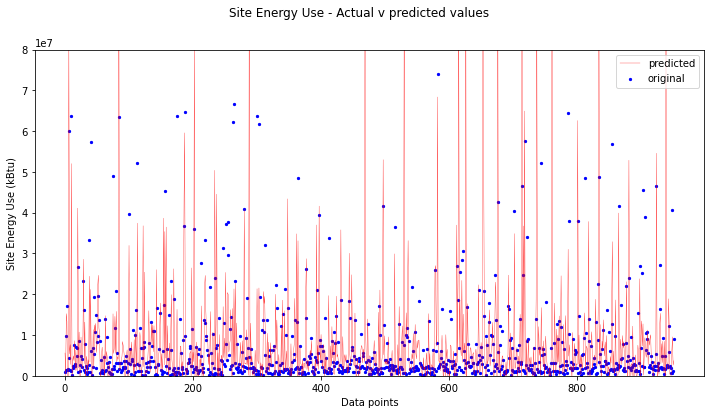

In [686]:
fig = plt.figure(figsize=(12,6))
x_ax = range(len(y_test))
plt.scatter(x_ax, y_test, s=5, color="blue", label="original")
plt.plot(x_ax, y_pred_lin, lw=0.3, color="red", label="predicted")
fig.suptitle('Site Energy Use - Actual v predicted values')
plt.ylabel('Site Energy Use (kBtu)')
plt.xlabel('Data points')
plt.ylim(0,80000000)
plt.legend()
plt.show()

__LASSO__

In [647]:
import time
start_time2 = time.time()

pipe_lasso = Pipeline(steps=[('preprocessor', preprocessor),
                             ('regressor', Lasso())])

params = {"regressor__alpha": [0.001, 1, 0.01], # Constant that multiplies the L1 term
          "regressor__max_iter": [10, 50, 100, 1000]} # maximum number of iterations.

grid_lasso = GridSearchCV(pipe_lasso, param_grid=params, cv=5,
                            scoring=('r2','neg_mean_absolute_error'),
                            return_train_score = True,
                            refit='neg_mean_absolute_error',
                            n_jobs = -1)


grid_lasso.fit(X_train, y_train)

y_pred_las=grid_lasso.predict(X_train)
mae_train2 = mean_absolute_error(y_pred_las,y_train)
r2_train2 = r2_score(y_pred_las,y_train)
print("MAE train: %.2f" % mae_train2)
print("R2 train: %.2f" % r2_train2)
print('Best parameters:', grid_lasso.best_params_)
print('Best score:', grid_lasso.best_score_)
tm2 = time.time() - start_time2
print("Running Time: %s seconds" % (tm2))

MAE train: 4289316.89
R2 train: 0.41
Best parameters: {'regressor__alpha': 1, 'regressor__max_iter': 10}
Best score: -4700367.4012400685
Running Time: 1.7964403629302979 seconds


In [648]:
y_pred_las=grid_lasso.predict(X_test)
mae_test2 = mean_absolute_error(y_pred_las, y_test)
r2_test2 = r2_score(y_test, y_pred_las)
print("MAE test: %.2f" % mae_test2)
print("R2 test: %.2f" % r2_test2)


MAE test: 4779221.76
R2 test: 0.63


__RIDGE__

In [649]:
import time
start_time3 = time.time()

pipe_ridge = Pipeline(steps=[('preprocessor', preprocessor),
                             ('regressor', Ridge())])

params = {"regressor__alpha": [0.001, 1, 0.01], 
          "regressor__max_iter": [10, 50, 100, 1000]}
             

grid_ridge = GridSearchCV(pipe_ridge, param_grid=params, cv=5,
                            scoring=('r2','neg_mean_absolute_error'),
                            return_train_score = True,
                            refit='neg_mean_absolute_error',
                            n_jobs = -1)


grid_ridge.fit(X_train, y_train)

y_pred_rid=grid_ridge.predict(X_train)
mae_train3 = mean_absolute_error(y_pred_rid,y_train)
r2_train3 = r2_score(y_pred_rid,y_train)
print("MAE train: %.2f" % mae_train3)
print("R2 train: %.2f" % r2_train3)
print('Best parameters:', grid_ridge.best_params_)
print('Best score:', grid_ridge.best_score_)
tm3 = time.time() - start_time3
print("Running Time: %s seconds" % (tm3))

MAE train: 4324331.99
R2 train: 0.41
Best parameters: {'regressor__alpha': 1, 'regressor__max_iter': 50}
Best score: -4680556.05158602
Running Time: 0.45261502265930176 seconds


In [650]:
y_pred_rid=grid_ridge.predict(X_test)

mae_test3 = mean_absolute_error(y_pred_rid, y_test)
r2_test3 = r2_score(y_test, y_pred_rid)

print("MAE test: %.2f" % mae_test3)
print("R2 test: %.2f" % r2_test3)


MAE test: 4799535.24
R2 test: 0.66


__ElasticNet Regression__

In [660]:
import time
start_time4 = time.time()
pipenet = Pipeline(steps=[('preprocessor', preprocessor),
                          ('regressor', ElasticNet())])

param_eNet = {"regressor__alpha": [0, 1, 0.1], # Constant that multiplies the penalty terms. Defaults to 1.0
                                                  # alpha=0 the penalty function reduces to the L1 (ridge) term
                                                  # alpha=1, we get the L2 (lasso) term.
              "regressor__l1_ratio": [.1, .5, .7, .9, .95, .99, 1], # The ElasticNet mixing parameter,
                                                                    # with 0 <= l1_ratio <= 1. 
                                                                    # For l1_ratio = 0 the penalty is an L2 penalty.
                                                                    # For l1_ratio = 1 it is an L1 penalty. 
                                                                    # For 0 < l1_ratio < 1, the penalty is a combination of L1 and L2.
              "regressor__max_iter": [10, 50, 100, 1000]} # The maximum number of iterations (default = 1000)
             
grid_cvnet = GridSearchCV(pipenet, 
                          param_grid=param_eNet, 
                          cv=5,
                          scoring=('r2','neg_mean_absolute_error'),
                          return_train_score = True,
                          refit='neg_mean_absolute_error',
                          n_jobs = -1)

grid_cvnet.fit(X_train, y_train)

y_pred_net=grid_cvnet.predict(X_train)
mae_train4 = mean_absolute_error(y_pred_net,y_train)
r2_train4 = r2_score(y_pred_net,y_train)

print("MAE train: %.2f" % mae_train4)
print("R2 train: %.2f" % r2_train4)
print('Best parameters:', grid_cvnet.best_params_)
print('Best score:', grid_cvnet.best_score_)
tm4 = time.time() - start_time4
print("Running Time: %s seconds" % (tm4))

MAE train: 4306433.40
R2 train: 0.07
Best parameters: {'regressor__alpha': 0.1, 'regressor__l1_ratio': 0.95, 'regressor__max_iter': 10}
Best score: -4552284.319692697
Running Time: 6.850861549377441 seconds


In [661]:
y_pred_net=grid_cvnet.predict(X_test)

mae_test4 = mean_absolute_error(y_pred_net, y_test)
r2_test4 = r2_score(y_test, y_pred_net)

print("MAE test: %.2f" % mae_test4)
print("R2 test: %.2f" % r2_test4)

MAE test: 4537289.07
R2 test: 0.66


__KNN Regression__

In [670]:
from sklearn import neighbors, metrics

import time
start_time5 = time.time()

pipe_knn = Pipeline(steps=[('preprocessor', preprocessor),
                       ('regressor', KNeighborsRegressor())])


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


# Fixer les valeurs des hyperparamètres à tester
param_grid = {'regressor__n_neighbors':[5, 7, 9, 11, 13, 15, 55]}

# Choisir un score à optimiser, ici l'accuracy (proportion de prédictions correctes)
#score = 'accuracy'

# Créer un classifieur kNN avec recherche d'hyperparamètre par validation croisée
clf = GridSearchCV(
                    pipe_knn, # un classifieur kNN
                    param_grid,     # hyperparamètres à tester
                    cv=5,           # nombre de folds de validation croisée
                    scoring=('r2','neg_mean_absolute_error'),   # score à optimiser
                    return_train_score = True,
                    refit='neg_mean_absolute_error',
                    n_jobs = -1)

clf.fit(X_train, y_train)

y_pred_clf=clf.predict(X_train)
mae_train5 = mean_absolute_error(y_pred_clf,y_train)
r2_train5 = r2_score(y_pred_clf,y_train)

print("MAE train: %.2f" % mae_train5)
print("R2 train: %.2f" % r2_train5)
print('Best parameters:', clf.best_params_)
print('Best score:', clf.best_score_)
tm5 = time.time() - start_time5
print("Running Time: %s seconds" % (tm5))


MAE train: 3024492.62
R2 train: 0.34
Best parameters: {'regressor__n_neighbors': 5}
Best score: -4072813.9970740923
Running Time: 3.3782172203063965 seconds


In [671]:
y_pred_clf=clf.predict(X_test)
mae_test5 = mean_absolute_error(y_pred_clf, y_test)
r2_test5 = r2_score(y_test, y_pred_clf)
print("MAE test: %.2f" % mae_test5)
print("R2 test: %.2f" % r2_test5)

MAE test: 4234646.65
R2 test: 0.43


__Support Vector Regression (SVR)__

In [680]:
from sklearn.svm import LinearSVR
import time
start_time6 = time.time()

pipesvr = Pipeline(steps=[('preprocessor', preprocessor),
                          ('regressor', LinearSVR())])

param_svr = {'regressor__epsilon' : [0.1, 1, 0.01 ], # Epsilon parameter in the epsilon-insensitive loss function (default=0)
             'regressor__C' : [0.1, 1, 0.01], # Regularization parameter. The strength of the regularization is inversely proportional to C.
             'regressor__loss' : ["epsilon_insensitive","squared_epsilon_insensitive"], # Specifies the loss function 
             'regressor__max_iter': [10, 100, 1000, 2000]} # The maximum number of iterations to be run (default=1000)

grid_cvsvr = GridSearchCV(pipesvr, 
                          param_grid=param_svr,
                          cv=5,
                          scoring=('r2','neg_mean_absolute_error'),
                          return_train_score = True,
                          refit='neg_mean_absolute_error',
                          n_jobs = -1)


grid_cvsvr.fit(X_train, y_train)

y_pred_svr=grid_cvsvr.predict(X_train)
mae_train6 = mean_absolute_error(y_pred_svr,y_train)
r2_train6 = r2_score(y_pred_svr,y_train)

print("MAE train: %.2f" % mae_train6)
print("R2 train: %.2f" % r2_train6)
print('Best parameters:', grid_cvsvr.best_params_)
print('Best score:', grid_cvsvr.best_score_)
tm6 = time.time() - start_time6
print("Running Time: %s seconds" % (tm6))

MAE train: 4274053.72
R2 train: 0.33
Best parameters: {'regressor__C': 0.1, 'regressor__epsilon': 1, 'regressor__loss': 'squared_epsilon_insensitive', 'regressor__max_iter': 100}
Best score: -4565689.457021204
Running Time: 2.314591407775879 seconds


In [681]:
y_pred_svr = grid_cvsvr.predict(X_test)
mae_test6 = mean_absolute_error(y_pred_svr, y_test)
r2_test6 = r2_score(y_test, y_pred_svr)
print("MAE test: %.2f" % mae_test6)
print("R2 test: %.2f" % r2_test6)

MAE test: 4652842.74
R2 test: 0.66


__RANDOM FOREST__

In [683]:
import time
start_time7 = time.time()

pipe_rfr = Pipeline(steps=[('preprocessor', preprocessor),
                          ('regressor', RandomForestRegressor())])

param_rfr = {'regressor__max_features' : ['sqrt', 'log2'], # The number of features to consider when looking for the best split
             'regressor__max_depth': [5, 15, 25, 50, 100], # The maximum depth of the tree
             'regressor__min_samples_split': [2, 5, 10], # The minimum number of samples required to split an internal node (default=2)
             'regressor__bootstrap' : [True, False], # Whether bootstrap samples are used when building trees
             'regressor__min_samples_leaf': [1,2,5,10]} # The minimum number of samples required to be at a leaf node (default=1)

grid_cvrfr = GridSearchCV(pipe_rfr,
                          param_grid=param_rfr,
                          cv=5,
                          scoring=('r2','neg_mean_absolute_error'),
                          return_train_score = True,
                          refit='neg_mean_absolute_error',
                          n_jobs = -1)


grid_cvrfr.fit(X_train, y_train)

y_pred_rfr = grid_cvrfr.predict(X_train)
mae_train7 = mean_absolute_error(y_pred_rfr,y_train)
r2_train7 = r2_score(y_pred_rfr,y_train)

print("MAE train: %.2f" % mae_train7)
print("R2 train: %.2f" % r2_train7)
print('Best parameters:', grid_cvrfr.best_params_)
print('Best score:', grid_cvrfr.best_score_)
tm7 = time.time() - start_time7
print("Running Time: %s seconds" % (tm7))

MAE train: 788.87
R2 train: 1.00
Best parameters: {'regressor__bootstrap': False, 'regressor__max_depth': 50, 'regressor__max_features': 'sqrt', 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 2}
Best score: -2795175.65837835
Running Time: 51.602460861206055 seconds


In [684]:
y_pred_rfr=grid_cvrfr.predict(X_test)
mae_test7 = mean_absolute_error(y_pred_rfr, y_test)
r2_test7 = r2_score(y_test, y_pred_rfr)
print("MAE test: %.2f" % mae_test7)
print("R2 test: %.2f" % r2_test7)

MAE test: 2632523.10
R2 test: 0.86


__XGBoost regression__

In [687]:
start_time8 = time.time()

pipe_xgb = Pipeline(steps=[('preprocessor', preprocessor),
                          ('regressor', xgb.XGBRegressor())])

param_xgb = {'regressor__gamma': [0.1, 0.25, 0.5, 1.0],
             'regressor__learning_rate' : [0.01, 1, 0.01], #step size shrinkage used to prevent overfitting. Range is [0,1]
             'regressor__max_depth': [6, 10, 15, 20, 50],
             'regressor__n_estimators': [25, 50, 100, 200]} # number of trees we want to build
                     
grid_cvxgb = GridSearchCV(pipe_xgb,
                          param_grid = param_xgb,
                          cv = 5,
                          scoring=('r2','neg_mean_absolute_error'),
                          return_train_score = True,
                          refit = 'neg_mean_absolute_error',
                          n_jobs = -1)

grid_cvxgb.fit(X_train, y_train)

y_pred_xgb = grid_cvxgb.predict(X_train)
mae_train8 = mean_absolute_error(y_pred_xgb,y_train)
r2_train8 = r2_score(y_pred_xgb,y_train)


print("MAE train: %.2f" % mae_train8)
print("R2 train: %.2f" % r2_train8)
print('Best parameters:', grid_cvxgb.best_params_)
print('Best score:', grid_cvxgb.best_score_)
tm8 = time.time() - start_time8
print("Running Time: %s seconds" % (tm8))


MAE train: 293.45
R2 train: 1.00
Best parameters: {'regressor__gamma': 0.25, 'regressor__learning_rate': 1, 'regressor__max_depth': 20, 'regressor__n_estimators': 200}
Best score: -2802995.4639661512
Running Time: 252.7774634361267 seconds


__XGBoost on Test data__

In [689]:
y_pred_xgb = grid_cvxgb.predict(X_test)
mae_test8 = mean_absolute_error(y_pred_xgb, y_test)
r2_test8 = r2_score(y_test, y_pred_xgb)
print("MAE test: %.2f" % mae_test8)
print("R2 test: %.2f" % r2_test8)

MAE test: 2878733.39
R2 test: 0.78


__Summary of Results on Site Energy Use__

In [690]:
results = ['R2_train', 'R2_test', 'MAE_train', 'MAE_test', 'Running_train_time(s)']
reg_met = {'Linear' : pd.Series([r2_train1, r2_test1, mae_train1, mae_test1, tm1],
                        index = results),
              'Lasso' : pd.Series([r2_train2, r2_test2, mae_train2, mae_test2, tm2],
                        index = results),
              'Ridge' : pd.Series([r2_train3, r2_test3, mae_train3, mae_test3, tm3],
                        index = results),
              'ElasticNet' : pd.Series([r2_train4, r2_test4, mae_train4, mae_test4, tm4],
                        index = results),
              'KNN' : pd.Series([r2_train5, r2_test5, mae_train5, mae_test5, tm5],
                        index = results),
              'SVM' : pd.Series([r2_train6, r2_test6, mae_train6, mae_test6, tm6],
                        index = results),
              'RandomForest' : pd.Series([r2_train7, r2_test7, mae_train7, mae_test7, tm7],
                        index = results),
              'XGBoost' : pd.Series([r2_train8, r2_test8, mae_train8, mae_test8, tm8],
                        index = results)}

# Creates Dataframe df_files_spec

df_results_SEU = pd.DataFrame(reg_met)
index = df_results_SEU.index
index. name = "Metrics"
df_results_SEU.round(2)


,Linear,Lasso,Ridge,ElasticNet,KNN,SVM,RandomForest,XGBoost
Metrics,,,,,,,,
R2_train,0.45,0.41,0.41,0.07,0.34,0.33,1.00,1.00
R2_test,0.65,0.63,0.66,0.66,0.43,0.66,0.86,0.78
MAE_train,4316342.36,4289316.89,4324331.99,4306433.40,3024492.62,4274053.72,788.87,293.45
MAE_test,4836633.48,4779221.76,4799535.24,4537289.07,4234646.65,4652842.74,2632523.10,2878733.39
Running_train_time(s),1.36,1.80,0.45,6.85,3.38,2.31,51.60,252.78


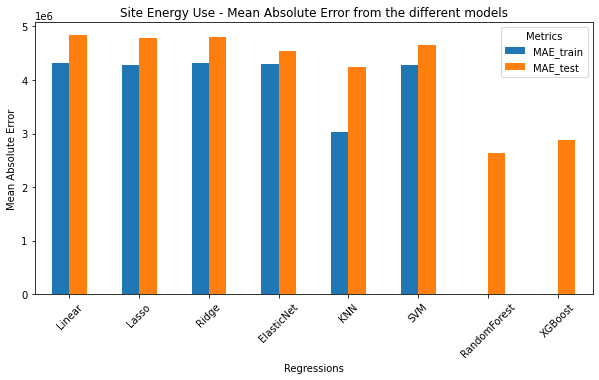

In [691]:
df_SEU = df_results_SEU.T
plt.rcParams["figure.figsize"] = (10, 5)
df_SEU1 = df_SEU[["MAE_test", "MAE_train"]].plot( y=["MAE_train", "MAE_test"], kind="bar", rot = 45)
plt.xlabel("Regressions")
plt.ylabel("Mean Absolute Error")
plt.title("Site Energy Use - Mean Absolute Error from the different models")
#plt. ylim()
plt.show()

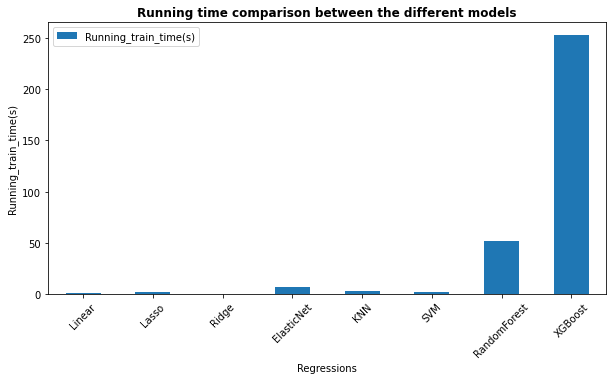

In [692]:
plt.rcParams["figure.figsize"] = (10, 5)
df_SEU2 = df_SEU.plot( y="Running_train_time(s)", kind="bar", rot = 45)
plt.xlabel("Regressions")
plt.ylabel("Running_train_time(s)")
plt.title('Running time comparison between the different models', weight = "bold")
plt.show()

In [695]:
def forecast_comp_1(y_true, y_pred, color=None, title=None):
    X_plot = [y_true.min(), y_true.max()]
    fig = plt.figure(figsize=(12,7))
    plt.scatter(y_true, y_pred, color='b', alpha=.4)
    plt.xlabel("Actual values")
    plt.ylabel("Predicted values")
    plt.title("Site Energy Use - Actual Values vs predicted values", 
              fontsize=18)
    plt.show()

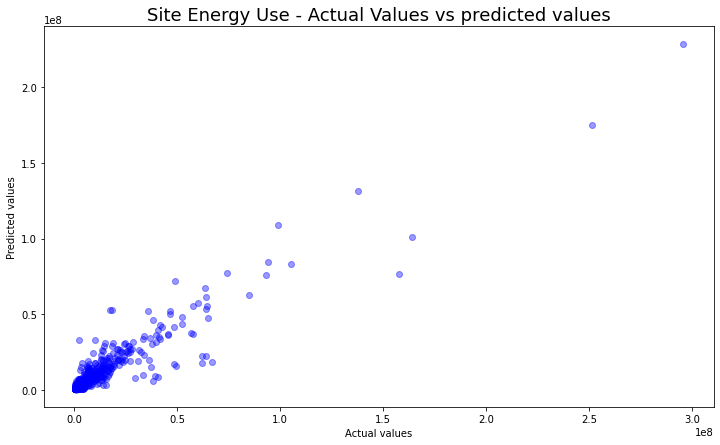

In [696]:
y2_pred_rfr = grid_cvrfr.predict(X_test)
forecast_comp_1(y_test, y2_pred_rfr, title="TotalGHGEmissions")

__Predictions on GHG Emissions__

In [698]:
# Linear regression
start_time11 = time.time()
pipe = Pipeline(steps=[('preprocessor', preprocessor),
                       ('regressor', LinearRegression())])

X = df_data_non_ener[num_data + cat_data]
y = df_data_non_ener['GHGEmissions(MetricTonsCO2e)']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


params = {"regressor__fit_intercept": [True, False],
          "regressor__normalize": [True, False]}

grid_cv = GridSearchCV(pipe, param_grid=params, cv=5,
                            scoring=('r2','neg_mean_absolute_error'),
                            return_train_score = True,
                            refit='neg_mean_absolute_error',
                            n_jobs = -1)

grid_cv.fit(X_train, y_train)

y_pred = grid_cv.predict(X_train)
mae_train11 = mean_absolute_error(y_pred,y_train)
r2_train11 = r2_score(y_pred,y_train)
tm11 = time.time() - start_time11
ypred_lin = grid_cv.predict(X_test)
mae_test11 = mean_absolute_error(ypred_lin, y_test)
r2_test11 = r2_score(y_test, ypred_lin)

# Lasso regression

start_time21 = time.time()

pipe_lasso = Pipeline(steps=[('preprocessor', preprocessor),
                             ('regressor', Lasso())])

params = {"regressor__alpha": [0.1, 3, 0.01], # Constant that multiplies the L1 term
          "regressor__max_iter": [10, 50, 100, 1000]} # maximum number of iterations.

grid_lasso = GridSearchCV(pipe_lasso, param_grid=params, cv=5,
                            scoring=('r2','neg_mean_absolute_error'),
                            return_train_score = True,
                            refit='neg_mean_absolute_error',
                            n_jobs = -1)


grid_lasso.fit(X_train, y_train)

y_pred_las=grid_lasso.predict(X_train)
mae_train21 = mean_absolute_error(y_pred_las,y_train)
r2_train21 = r2_score(y_pred_las,y_train)

tm21 = time.time() - start_time21

y_pred_las=grid_lasso.predict(X_test)
mae_test21 = mean_absolute_error(y_pred_las, y_test)
r2_test21 = r2_score(y_test, y_pred_las)

# Ridge regression

start_time31 = time.time()

pipe_ridge = Pipeline(steps=[('preprocessor', preprocessor),
                             ('regressor', Ridge())])

params = {"regressor__alpha": [0.1, 1, 0.01], 
          "regressor__max_iter": [10, 50, 100, 1000]}
             
grid_ridge = GridSearchCV(pipe_ridge, param_grid=params, cv=5,
                            scoring=('r2','neg_mean_absolute_error'),
                            return_train_score = True,
                            refit='neg_mean_absolute_error',
                            n_jobs = -1)


grid_ridge.fit(X_train, y_train)

y_pred_rid=grid_ridge.predict(X_train)
mae_train31 = mean_absolute_error(y_pred_rid,y_train)
r2_train31 = r2_score(y_pred_rid,y_train)
tm31 = time.time() - start_time31
y_pred_rid=grid_ridge.predict(X_test)
mae_test31 = mean_absolute_error(y_pred_rid, y_test)
r2_test31 = r2_score(y_test, y_pred_rid)

# ElasicNet regression

start_time41 = time.time()
pipenet = Pipeline(steps=[('preprocessor', preprocessor),
                          ('regressor', ElasticNet())])

param_eNet = {"regressor__alpha": [0.1, 1, 0.01],
              "regressor__l1_ratio": [.1, .5, .7, .9, .95, .99, 1],
              "regressor__max_iter": [10, 50, 100, 1000]}

grid_cvnet = GridSearchCV(pipenet, 
                          param_grid=param_eNet, 
                          cv=5,
                          scoring=('r2','neg_mean_absolute_error'),
                          return_train_score = True,
                          refit='neg_mean_absolute_error',
                          n_jobs = -1)

grid_cvnet.fit(X_train, y_train)
y_pred_net=grid_cvnet.predict(X_train)

mae_train41 = mean_absolute_error(y_pred_net,y_train)
r2_train41 = r2_score(y_pred_net,y_train)

tm41 = time.time() - start_time41

y_pred_net = grid_cvnet.predict(X_test)
mae_test41 = mean_absolute_error(y_pred_net, y_test)
r2_test41 = r2_score(y_test, y_pred_net)

# KNN regresion

start_time51 = time.time()

pipe_knn = Pipeline(steps=[('preprocessor', preprocessor),
                       ('regressor', KNeighborsRegressor())])

# Hyperparameters input values
param_grid = {'regressor__n_neighbors':[5, 7, 9, 11, 13, 15]}

# Créer un classifieur kNN avec recherche d'hyperparamètre par validation croisée
clf = GridSearchCV(
                    pipe_knn, # kNN regressor
                    param_grid,     # hyperparameters to test
                    cv=5,           # number of folds of the cross validation
                    scoring=('r2','neg_mean_absolute_error'),   
                    return_train_score = True,
                    refit='neg_mean_absolute_error',
                    n_jobs = -1)

clf.fit(X_train, y_train)

y_pred_clf= clf.predict(X_train)

mae_train51 = mean_absolute_error(y_pred_clf,y_train)
r2_train51 = r2_score(y_pred_clf,y_train)

tm51 = time.time() - start_time51

y_pred_clf=clf.predict(X_test)
mae_test51 = mean_absolute_error(y_pred_clf, y_test)
r2_test51 = r2_score(y_test, y_pred_clf)

# SVR regression

start_time61 = time.time()

pipesvr = Pipeline(steps=[('preprocessor', preprocessor),
                          ('regressor', LinearSVR())])

param_svr = {'regressor__epsilon' : [0, 0.01, 0.1, 0.5, 1, 2], # Epsilon parameter in the epsilon-insensitive loss function (default=0)
             'regressor__C' : [0.1, 1, 2, 3, 4, 5], # Regularization parameter. The strength of the regularization is inversely proportional to C.
             'regressor__loss' : ["epsilon_insensitive","squared_epsilon_insensitive"], # Specifies the loss function 
             'regressor__max_iter': [10, 100, 1000, 2000]} # The maximum number of iterations to be run (default=1000)

grid_cvsvr = GridSearchCV(pipesvr, 
                          param_grid=param_svr,
                          cv=5,
                          scoring=('r2','neg_mean_absolute_error'),
                          return_train_score = True,
                          refit='neg_mean_absolute_error',
                          n_jobs = -1)


grid_cvsvr.fit(X_train, y_train)

y_pred_svr=grid_cvsvr.predict(X_train)
mae_train61 = mean_absolute_error(y_pred_svr,y_train)
r2_train61 = r2_score(y_pred_svr,y_train)

tm61 = time.time() - start_time61

y_pred_svr = grid_cvsvr.predict(X_test)
mae_test61 = mean_absolute_error(y_pred_svr, y_test)
r2_test61 = r2_score(y_test, y_pred_svr)

# RandomForest

start_time71 = time.time()

pipe_rfr = Pipeline(steps=[('preprocessor', preprocessor),
                          ('regressor', RandomForestRegressor())])

param_rfr = {'regressor__max_features' : ['sqrt', 'log2'], # The number of features to consider when looking for the best split
             'regressor__max_depth': [5, 15, 25, 50], # The maximum depth of the tree
             'regressor__min_samples_split': [2, 5, 10], # The minimum number of samples required to split an internal node (default=2)
             'regressor__bootstrap' : [True, False], # Whether bootstrap samples are used when building trees
             'regressor__min_samples_leaf': [1,2,5,10]} # The minimum number of samples required to be at a leaf node (default=1)

grid_cvrfr = GridSearchCV(pipe_rfr,
                          param_grid=param_rfr,
                          cv=5,
                          scoring=('r2','neg_mean_absolute_error'),
                          return_train_score = True,
                          refit='neg_mean_absolute_error',
                          n_jobs = -1)


grid_cvrfr.fit(X_train, y_train)

y_pred_rfr = grid_cvrfr.predict(X_train)
mae_train71 = mean_absolute_error(y_pred_rfr,y_train)
r2_train71 = r2_score(y_pred_rfr,y_train)
tm71 = time.time() - start_time71
y_pred_rfr = grid_cvrfr.predict(X_test)
mae_test71 = mean_absolute_error(y_pred_rfr, y_test)
r2_test71 = r2_score(y_test, y_pred_rfr)

# XGBoost Regressor

start_time81 = time.time()

pipe_xgb = Pipeline(steps=[('preprocessor', preprocessor),
                          ('regressor', xgb.XGBRegressor())])

param_xgb = {'regressor__gamma': [0, 0.25, 0.5, 1.0],
             'regressor__learning_rate' : [0.01, 1, 0.01], #step size shrinkage used to prevent overfitting. Range is [0,1]
             'regressor__max_depth': [6, 10, 15, 20, 50],
             'regressor__n_estimators': [25, 50, 100, 200]} # number of trees we want to build
             
grid_cvxgb = GridSearchCV(pipe_xgb,
                          param_grid=param_xgb,
                          cv=5,
                          scoring=('r2','neg_mean_absolute_error'),
                          return_train_score = True,
                          refit='neg_mean_absolute_error',
                          n_jobs = -1)

grid_cvxgb.fit(X_train, y_train)

y_pred_xgb = grid_cvxgb.predict(X_train)
mae_train81 = mean_absolute_error(y_pred_xgb,y_train)
r2_train81 = r2_score(y_pred_xgb,y_train)

tm81 = time.time() - start_time81

y_pred_xgb = grid_cvxgb.predict(X_test)
mae_test81 = mean_absolute_error(y_pred_xgb, y_test)
r2_test81 = r2_score(y_test, y_pred_xgb)


# -----------------------------------------------------------------------------------------------

results = ['R2_train', 'R2_test', 'MAE_train', 'MAE_test', 'Running_train_time(s)']
reg_met_GHG = {'Linear' : pd.Series([r2_train11, r2_test11, mae_train11, mae_test11, tm11],
                        index = results),
              'Lasso' : pd.Series([r2_train21, r2_test21, mae_train21, mae_test21, tm21],
                        index = results),
              'Ridge' : pd.Series([r2_train31, r2_test31, mae_train31, mae_test31, tm31],
                        index = results),
              'ElasticNet ' : pd.Series([r2_train41, r2_test41, mae_train41, mae_test41, tm41],
                        index = results),
              'KNN' : pd.Series([r2_train51, r2_test51, mae_train51, mae_test51, tm51],
                        index = results),
              'SVM' : pd.Series([r2_train61, r2_test61, mae_train61, mae_test61, tm61],
                        index = results),
              'RandomForest' : pd.Series([r2_train71, r2_test71, mae_train71, mae_test71, tm71],
                        index = results),
              'XGBoost' : pd.Series([r2_train81, r2_test81, mae_train81, mae_test81, tm81],
                        index = results)}

# Creates Dataframe df_results_GHG

df_results_GHG = pd.DataFrame(reg_met_GHG)
index = df_results_GHG.index
index. name = "Metrics GHG"
hide_toggle()
round(df_results_GHG, 3)


,Linear,Lasso,Ridge,ElasticNet,KNN,SVM,RandomForest,XGBoost
Metrics GHG,,,,,,,,
R2_train,0.223,-0.192,0.180,0.007,-0.736,-17.645,1.000,0.854
R2_test,0.520,0.539,0.537,0.493,0.266,0.150,0.862,0.835
MAE_train,146.981,139.455,147.530,137.796,102.181,119.197,0.045,38.350
MAE_test,162.265,148.069,160.809,150.840,126.053,127.858,78.683,80.972
Running_train_time(s),0.263,1.082,0.468,4.579,3.047,11.573,40.665,251.983


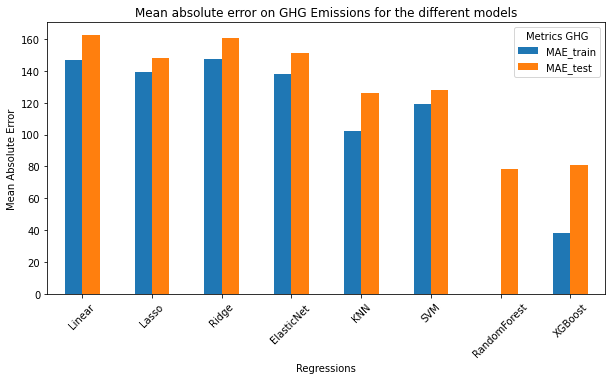

In [699]:
df_GHG = df_results_GHG.T
plt.rcParams["figure.figsize"] = (10, 5)
df_GHG1 = df_GHG[["MAE_test", "MAE_train"]].plot( y=["MAE_train", "MAE_test"], kind="bar", rot = 45)
plt.xlabel("Regressions")
plt.ylabel("Mean Absolute Error")
plt.title("Mean absolute error on GHG Emissions for the different models")

plt.show()

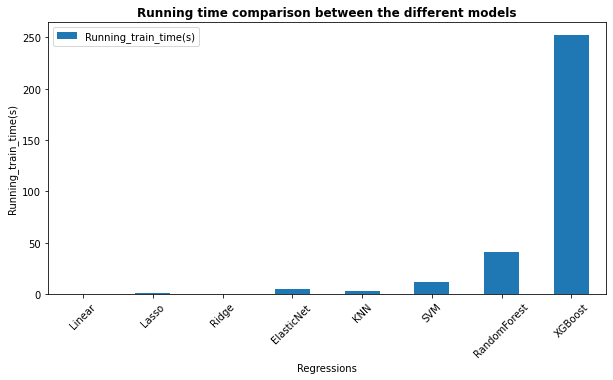

In [700]:
plt.rcParams["figure.figsize"] = (10, 5)
df_GHG2 = df_GHG.plot( y="Running_train_time(s)", kind="bar", rot = 45)
plt.xlabel("Regressions")
plt.ylabel("Running_train_time(s)")
plt.title('Running time comparison between the different models', weight = "bold")
plt.show()

In [701]:
def forecast_comp_2(y_true, y_pred, color=None, title=None):
    X_plot = [y_true.min(), y_true.max()]
    fig = plt.figure(figsize=(12,8))
    plt.scatter(y_true, y_pred, color='g', alpha=.4)
    plt.xlabel("Actual values")
    plt.ylabel("Predicted values")
    plt.title("GHG Emissions - Actual Values vs predicted values", 
              fontsize=18)
    plt.show()

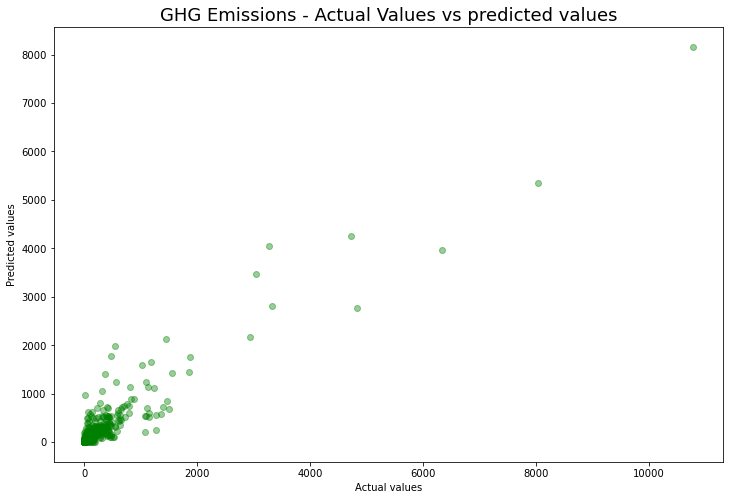

In [702]:
y1_pred_rfr = grid_cvrfr.predict(X_test)
forecast_comp_2(y_test, y1_pred_rfr, title="TotalGHGEmissions")


In [565]:
X

,NumberofBuildings,NumberofFloors,PropertyGFATotal,AgeofBuilding,MeanBuildingGFA,MeanFloorGFA,BuildingGFApct,ParkingGFApct,DataYear,BuildingType,PrimaryPropertyType,Neighborhood,LargestPropertyUseType
0,1.0,12.0,88434,88,88434.0,7369.500000,1.000000,0.000000,2015,NonResidential,Hotel,Downtown,Hotel
1,1.0,12.0,88434,89,88434.0,7369.500000,1.000000,0.000000,2016,NonResidential,Hotel,Downtown,Hotel
2,1.0,11.0,103566,19,103566.0,9415.090909,0.854547,0.145453,2015,NonResidential,Hotel,Downtown,Hotel
3,1.0,11.0,103566,20,103566.0,9415.090909,0.854547,0.145453,2016,NonResidential,Hotel,Downtown,Hotel
4,1.0,41.0,961990,46,961990.0,23463.170732,1.000000,0.000000,2015,NonResidential,Hotel,Downtown,Hotel
...,...,...,...,...,...,...,...,...,...,...,...,...,...
3168,1.0,1.0,18261,34,18261.0,18261.000000,1.000000,0.000000,2016,Nonresidential COS,Other,Delridge Neighborhoods,Other - Recreation
3169,1.0,1.0,16000,12,16000.0,16000.000000,1.000000,0.000000,2016,Nonresidential COS,Other,Downtown,Other - Recreation
3170,1.0,1.0,13157,42,13157.0,13157.000000,1.000000,0.000000,2016,Nonresidential COS,Other,Magnolia / Queen Anne,Other - Recreation
3171,1.0,1.0,14101,27,14101.0,14101.000000,1.000000,0.000000,2016,Nonresidential COS,Mixed Use Property,Greater Duwamish,Other - Recreation


In [566]:
feature_importance = grid_cvrfr.fit(X_train, y_train).named_steps['regressor'].best_estimator_.regressor_.feature_importances_ 
features_names = get_feature_names(grid_cvrfr.fit(X_train, y_train).named_steps['preprocessor'])
std = np.std([
    tree.feature_importances_ for tree in grid_cvrfr.fit(X_train, y_train).named_steps['regressor'].best_estimator_.regressor_], axis=0)
df_feature_importance = pd.Series(feature_importance, index=features_names)

fig, ax = plt.subplots(figsize=(12,8))
df_feature_importance.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances du modèle RandomForestRegressor sur les émissions de CO2", fontdict=font_title)
ax.set_ylabel("Diminution moyenne des impuretés")
fig.tight_layout()

AttributeError: 'GridSearchCV' object has no attribute 'named_steps'